## Clean Technologies 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
categories = pd.read_excel('../data/categories.xls')
categories = categories.fillna(method='ffill')
categories.columns = ['sector','technology_group','technology','description','technology_term','source']
categories.head()

,sector,technology_group,technology,description,technology_term,source
0,Energy,Solar energy sources,solar PV,Also “solar photovoltaic”; technology of using...,"photovoltaic, PV, “solar cell”",https://www.ctc-n.org/technologies/solar-pv
1,Energy,Solar energy sources,concentrated solar power (CSP),Technology of producing electricity by concent...,"“concentrated solar power”, CSP, “concentrated...",https://setis.ec.europa.eu/technologies/concen...
2,Energy,Solar energy sources,solar heating,Technology of capturing the sun's radiation an...,“solar heating”,https://www.ctc-n.org/technologies/solar-heating
3,Energy,Solar energy sources,solar dryer,"Technology of drying substances, especially fo...",“solar dryer”,https://www.ctc-n.org/technologies/solar-dryer
4,Energy,Solar energy sources,solar water pump,Technology of powering electrical water pumps ...,“solar water pump”,https://www.ctc-n.org/technologies/solar-water...


In [3]:
matrix = []
for term in categories['technology_term']:
    row = [x.strip() for x in term.split(',')]
    row = [i.replace('“', '').replace('”', '') for i in row]
    matrix.append(row)
categories['technology_term'] = matrix

---

In [4]:
#https://data.europa.eu/euodp/en/data/dataset/cordisH2020projects

In [5]:
cordish2020 = pd.read_excel('../data/cordis-h2020projects.xlsx')
#cordish2020 = pd.read_csv('../data/cordis-h2020projects.csv', sep=";")

In [6]:
cordish2020.columns

Index(['rcn', 'id', 'acronym', 'status', 'programme', 'topics',
       'frameworkProgramme', 'title', 'startDate', 'endDate', 'projectUrl',
       'objective', 'totalCost', 'ecMaxContribution', 'call', 'fundingScheme',
       'coordinator', 'coordinatorCountry', 'participants',
       'participantCountries', 'subjects'],
      dtype='object')

In [7]:
cordish2020['totalCost'] = [float(str(i).replace(',', '.')) for i in cordish2020['totalCost']]
cordish2020['ecMaxContribution'] = [float(str(i).replace(',', '.')) for i in cordish2020['ecMaxContribution']]

In [8]:
cordish2020['startDate'] = cordish2020['startDate'].map(pd.Timestamp)
cordish2020['endDate'] = cordish2020['endDate'].map(pd.Timestamp)

In [9]:
# Total of proyects
len(cordish2020)

24554

Objective example

---

In [10]:
cordish2020.loc[13]['objective']

'Neurological diseases cause enormous suffering and a great economic burden. Almost 20 million Europeans are affected by the most frequently occurring and disabling disease entities, such as stroke, Alzheimerâ€™s disease (AD), or multiple sclerosis (MS), and these numbers do not include the large group of rare diseases that affect the CNS. Overall, the annual costs for patient care amount to 400 billion Euros. Common features of many neurological diseases are a vascular pathology with impaired blood-brain barrier (BBB) function or with reduced blood flow and inflammatory changes. As the two are often associated, disentangling their intricate and mutual relationship is a major task for translational neuroscience that could improve the treatment of many neurological diseases. At the cellular level, key players are brain endothelial cells as the building blocks of cerebral vessels and macrophages as the main inflammatory cells of the brain. Recent discoveries indicate that endothelial cel

---

### Deterministic text labeling, Flashtext for easy regex

In [11]:
from flashtext import KeywordProcessor

In [12]:
def extract(vec, dictionary, info=False):
    empty = []
    for line in vec:
        empty.append(dictionary.extract_keywords(line, span_info=info))
    return empty

In [13]:
# unique list of technology group
technology_group = list(categories['technology_group'].unique())
len(technology_group)

24

In [14]:
dictionary1 = KeywordProcessor()
dictionary1.add_keywords_from_list(technology_group)
extracted1 = extract(cordish2020['objective'], dictionary1)
cordish2020['matches_group'] = [list(set(i)) if len(i)>0 else '' for i in extracted1]
cordish2020['count_matches_group'] = [len(i) for i in extracted1]
cordish2020['count_unique_matches_group'] = [len(set(i)) for i in extracted1]

In [15]:
# unique list of technology term
technology_term = [y for x in categories['technology_term'] for y in x if y != '']
len(technology_term)

223

In [16]:
#adding the new list of terms
dictionary2 = KeywordProcessor()
dictionary2.add_keywords_from_list(technology_term)
extracted2 = extract(cordish2020['objective'], dictionary2)
cordish2020['matches_technology'] = [list(set(i)) if len(i)>0 else '' for i in extracted2]
cordish2020['count_matches_technology'] = [len(i) for i in extracted2]
cordish2020['count_unique_matches_technology'] = [len(set(i)) for i in extracted2]

In [17]:
#cordish2020.head()

In [18]:
# filter only the rows with at least one match
cordish2020['count_matches'] = cordish2020['count_matches_group'] + cordish2020['count_matches_technology'] 
cordish2020matches = cordish2020[cordish2020['count_matches_technology'] > 0 ] #at least one match with technology term

In [19]:
cordish2020matches.columns

Index(['rcn', 'id', 'acronym', 'status', 'programme', 'topics',
       'frameworkProgramme', 'title', 'startDate', 'endDate', 'projectUrl',
       'objective', 'totalCost', 'ecMaxContribution', 'call', 'fundingScheme',
       'coordinator', 'coordinatorCountry', 'participants',
       'participantCountries', 'subjects', 'matches_group',
       'count_matches_group', 'count_unique_matches_group',
       'matches_technology', 'count_matches_technology',
       'count_unique_matches_technology', 'count_matches'],
      dtype='object')

In [20]:
len(cordish2020matches)

2052

In [21]:
print(len(cordish2020matches)/len(cordish2020))

0.0835709049442046


In [22]:
#this is the list we need to compare with the probabilistic
cordish2020matches.id[:20]

2      815147
5      835398
14     826097
16     835541
33     812602
43     811592
45     847641
66     805344
69     779606
75     818470
106    799408
126    786483
131    841910
132    838686
134    842633
149    820892
159    814400
185    830036
190    836317
205    814106
Name: id, dtype: int64

In [23]:
cordish2020matches.sort_values('count_matches', ascending=False).head(10)

,rcn,id,acronym,status,programme,topics,frameworkProgramme,title,startDate,endDate,...,participants,participantCountries,subjects,matches_group,count_matches_group,count_unique_matches_group,matches_technology,count_matches_technology,count_unique_matches_technology,count_matches
3745,200472,654462,STEMM-CCS,SIGNED,H2020-EU.3.3.2.3.,LCE-15-2015,H2020,Strategies for Environmental Monitoring of Mar...,2016-03-01,2020-02-29,...,UNIVERSITETET I TROMSOE - NORGES ARKTISKE UNIV...,NO;UK;AT;DE;NL,NaN,"[Storage, CCS]",15,2,"[carbon capture and storage, CCS]",13,2,28
17201,199423,691712,ACT,SIGNED,H2020-EU.3.3.2.;H2020-EU.3.3.3.;H2020-EU.3.3.4.,LCE-18-2015,H2020,Accellerating CCS technologies as a new low-ca...,2016-02-01,2021-01-31,...,ETHNIKO KENTRO EREVNAS KAI TECHNOLOGIKIS ANAPT...,EL;UK;DE;RO;TR;NL;ES;NO;CH,NaN,"[Storage, CCS]",14,2,[CCS],13,1,27
2580,197010,673782,FLOATMAST,CLOSED,H2020-EU.3.3.;H2020-EU.2.3.1.,SIE-01-2014-1,H2020,An Innovative Wind Resource Assessment Tension...,2015-06-01,2015-11-30,...,STREAMLINED SYMVOULI MECHANIKI EPE,EL,NaN,[Wind],15,1,"[offshore wind, onshore wind]",9,2,24
1784,198559,698136,WITRO,CLOSED,H2020-EU.3.3.;H2020-EU.2.3.1.,SIE-01-2015-1,H2020,Wind and Turbulence Radar for Offshore wind en...,2015-09-01,2015-12-31,...,NaN,NaN,NaN,[Wind],21,1,[offshore wind],1,1,22
22707,215270,794562,Small-scale CSP,SIGNED,H2020-EU.1.3.2.,MSCA-IF-2017,H2020,Numerical and experimental analysis of a novel...,2018-06-01,2020-05-31,...,NaN,NaN,NaN,[Storage],7,1,"[renewable energy, concentrated solar power, t...",15,6,22
11216,194405,645963,SENSIBLE,SIGNED,H2020-EU.3.3.,LCE-08-2014,H2020,Storage-Enabled Sustainable Energy for Buildin...,2015-01-01,2018-12-31,...,SIEMENS SA;MEADOWS OZONE ENERGY SERVICES LTD.;...,PT;UK;ES;DE;FR;FI,NaN,"[Storage, Energy management]",13,2,"[renewable energy, thermal storage, energy sto...",7,5,20
18498,210955,739615,acteno,CLOSED,H2020-EU.2.3.2.2.,INNOSUP-02-2016,H2020,Industrial Energy Storage Integration - develo...,2017-09-01,2018-08-31,...,NaN,NaN,NaN,[Storage],14,1,"[energy storage, renewable energy]",5,2,19
19944,207129,744518,FLOWSPA,CLOSED,H2020-EU.3.3.;H2020-EU.2.1.1.;H2020-EU.2.3.1.,SMEInst-09-2016-2017,H2020,Floating Offshore Wind Support Platform and As...,2017-02-01,2017-09-30,...,NaN,NaN,NaN,[Wind],11,1,[offshore wind],8,1,19
6939,213067,779541,REMOTE,SIGNED,H2020-EU.3.3.8.2.;H2020-EU.3.3.8.3.,FCH-02-12-2017,H2020,Remote area Energy supply with Multiple Option...,2018-01-01,2021-12-31,...,IRIS SRL;ETHNIKO KENTRO EREVNAS KAI TECHNOLOGI...,IT;EL;DK;NO;BE;FR,NaN,"[Storage, Fuel, Wind]",7,3,"[micro-grid, energy storage, fuel cell, PV, CHP]",12,5,19
8750,197929,671396,AutoRE,SIGNED,H2020-EU.3.3.8.1.,FCH-02.5-2014,H2020,AUTomotive deRivative Energy system,2015-08-01,2018-07-31,...,"SVEUCILISTE U SPLITU, FAKULTET ELEKTROTEHNIKE,...",HR;EL;NO;CH;DE;IT,NaN,[Fuel],7,1,"[combined heat and power, CHP, fuel cell]",11,3,18


There is one hypthesis here:  
The more count matches you have the better the accuracy to detect technology terms in the objective text  
Might be solved with statistical sampling. For each count match, select a sample check manually the accuracy  
http://www.marknagelberg.com/using-python-to-figure-out-sample-sizes-for-your-study/

EDA
1. Group by month and count over the time
2. Group by month and sum the total cost over the time
3. Group by country coordinator and count

In [24]:
dfy = cordish2020matches.groupby(cordish2020matches['startDate'].map(lambda x: x.year)).count()['id']

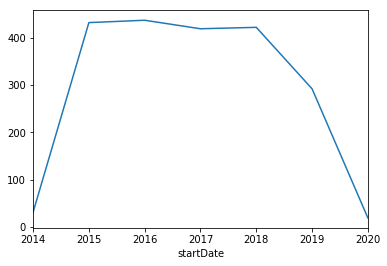

In [25]:
dfy.plot()

In [26]:
dfc = cordish2020matches.groupby(cordish2020matches['startDate'].map(lambda x: x.year)).sum()['ecMaxContribution']

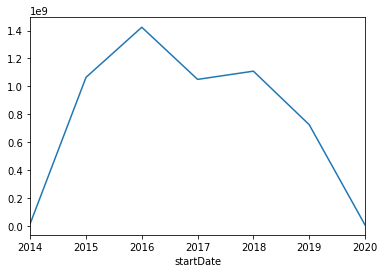

In [27]:
dfc.plot()

In [28]:
df_c = cordish2020matches.groupby(['coordinator','coordinatorCountry']).count()['id'].sort_values(ascending=False).reset_index()
df_c.columns = ['coordinator','coordinatorCountry','count']

In [29]:
df_c.head(20)

,coordinator,coordinatorCountry,count
0,COMMISSARIAT A L ENERGIE ATOMIQUE ET AUX ENERG...,FR,29
1,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE CNRS,FR,29
2,THE CHANCELLOR MASTERS AND SCHOLARS OF THE UNI...,UK,24
3,FRAUNHOFER GESELLSCHAFT ZUR FOERDERUNG DER ANG...,DE,23
4,Teknologian tutkimuskeskus VTT Oy,FI,18
5,AGENCIA ESTATAL CONSEJO SUPERIOR DEINVESTIGACI...,ES,16
6,ECOLE POLYTECHNIQUE FEDERALE DE LAUSANNE,CH,15
7,DANMARKS TEKNISKE UNIVERSITET,DK,14
8,DEUTSCHES ZENTRUM FUER LUFT - UND RAUMFAHRT EV,DE,13
9,FUNDACION TECNALIA RESEARCH & INNOVATION,ES,13


In [30]:
df_c = cordish2020matches.groupby(['coordinator','coordinatorCountry']).sum()['ecMaxContribution'].sort_values(ascending=False).reset_index()
df_c.columns = ['coordinator','coordinatorCountry','sum']

In [31]:
df_c.head(20)

,coordinator,coordinatorCountry,sum
0,ELEMENT ENERGY LIMITED,UK,1.314373e+08
1,COMMISSARIAT A L ENERGIE ATOMIQUE ET AUX ENERG...,FR,1.215225e+08
2,FRAUNHOFER GESELLSCHAFT ZUR FOERDERUNG DER ANG...,DE,1.035966e+08
3,FUNDACION TECNALIA RESEARCH & INNOVATION,ES,1.017493e+08
4,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE CNRS,FR,8.242696e+07
5,Teknologian tutkimuskeskus VTT Oy,FI,7.255569e+07
6,SINTEF AS,NO,6.152278e+07
7,RINA CONSULTING SPA,IT,5.151408e+07
8,DEUTSCHES ZENTRUM FUER LUFT - UND RAUMFAHRT EV,DE,4.993476e+07
9,ACONDICIONAMIENTO TARRASENSE ASSOCIACION,ES,4.880792e+07


In [32]:
def get_terms_matrix(vector_of_terms, all_terms):
    matrix = []
    for vector in vector_of_terms:
        ind_vector = [0] * len(all_terms)
        for v in vector:
            for idx, i in enumerate(all_terms):
                if v == i:
                    ind_vector[idx] = 1
        matrix.append(ind_vector)
    table = pd.DataFrame(matrix)
    return table

In [33]:
all_technology_terms = [i for i in set([*list(categories['technology_group']),*list(technology_term)])]

In [34]:
len(all_technology_terms)

235

In [35]:
all_technology_terms[:10]

['compressed gas',
 'efficient lighting',
 'demand-side energy management',
 'pulp and paper drying',
 'low GHG steel',
 'remote area power supply',
 'alternative to meat',
 'thermal storage',
 'landfill aerobic biological treatment',
 'soil protection']

In [36]:
#expected to have 225 columns
matches_technology_table = get_terms_matrix(list(cordish2020matches['matches_technology']), all_technology_terms)
matches_group_table = get_terms_matrix(list(cordish2020matches['matches_group']), all_technology_terms)

In [37]:
matches_table = matches_group_table + matches_technology_table
matches_table.columns = all_technology_terms
matches_table['number_unique_terms'] = matches_table.sum(axis=1)

In [38]:
matches_table.head()

,compressed gas,efficient lighting,demand-side energy management,pulp and paper drying,low GHG steel,remote area power supply,alternative to meat,thermal storage,landfill aerobic biological treatment,soil protection,...,solar cell,energy storage,gasification of waste,management of forest,lightweight transport,gasification of MSW,Forest protection,soil treatment,solar dryer,number_unique_terms
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [39]:
len(matches_table) == len(cordish2020matches)

True

In [40]:
full_table_tech_matches = pd.concat([cordish2020matches.reset_index(), matches_table], axis=1).sort_values(['count_matches','number_unique_terms'], ascending=False).reset_index()

In [41]:
len(full_table_tech_matches)

2052

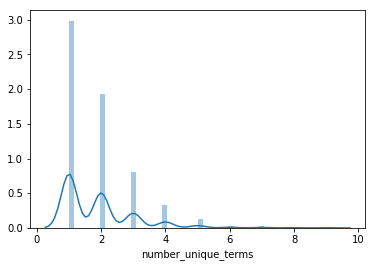

In [42]:
import seaborn as sns
sns.distplot(full_table_tech_matches['number_unique_terms'])

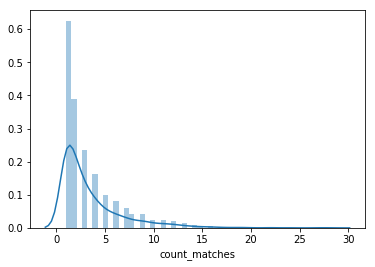

In [43]:
sns.distplot(full_table_tech_matches['count_matches'])

In [44]:
full_table_tech_matches.groupby('count_matches').count()['number_unique_terms']

count_matches
1     693
2     433
3     259
4     180
5     111
6      89
7      67
8      45
9      45
10     28
11     27
12     23
13     15
14     10
15      7
16      6
17      3
18      2
19      3
20      1
22      2
24      1
27      1
28      1
Name: number_unique_terms, dtype: int64

In [45]:
#for i, j in zip(full_table_tech_matches[full_table_tech_matches['count_matches'] ==2]['matches_technology'],full_table_tech_matches[full_table_tech_matches['count_matches'] ==2]['matches_group']):
#    print(i, j)

In [46]:
#full_table_tech_matches.columns[:35]#.head()

In [47]:
#for i in full_table_tech_matches.columns:
#    print(i)
#count_matches: each time a term in the glossary of 225 terms appear
#number_unique_terms: 

In [48]:
full_table_tech_matches[['id','acronym','title','objective','startDate','endDate','ecMaxContribution','matches_group','matches_technology','number_unique_terms','count_matches']].to_csv('../data/tech.csv')

In [49]:
termsT = full_table_tech_matches.iloc[:,33:-1].T
termsT['sum'] = termsT.sum(axis=1)

In [50]:
#termsT.sort_values('sum', ascending=False)

In [51]:
len(termsT[termsT['sum']>0])/len(termsT)

0.4827586206896552

In [52]:
#all_terms

In [53]:
#data = pd.read_csv('../data/tech.csv')

In [54]:
#len(data)

In [55]:
#data.tail(30)

---
### Syntactic probabilistic classification using spacy and fuzzywuzzy

In [56]:
import spacy
import numpy as np
from spacy import displacy
from collections import Counter
import en_core_web_sm
from fuzzywuzzy import process, fuzz
import re
nlp = en_core_web_sm.load()
import textdistance as tx
import unicodedata
from textdistance.algorithms import vector_based

In [57]:
def clean(string):
    return re.sub(r'[-\s]+', '-',
                str(
                    re.sub(r'[^\w\s-]', '',
                        unicodedata.normalize('NFKD', string)
                    .strip()
                   )))

Objective example

---

In [58]:
cordish2020.loc[13]['objective']

'Neurological diseases cause enormous suffering and a great economic burden. Almost 20 million Europeans are affected by the most frequently occurring and disabling disease entities, such as stroke, Alzheimerâ€™s disease (AD), or multiple sclerosis (MS), and these numbers do not include the large group of rare diseases that affect the CNS. Overall, the annual costs for patient care amount to 400 billion Euros. Common features of many neurological diseases are a vascular pathology with impaired blood-brain barrier (BBB) function or with reduced blood flow and inflammatory changes. As the two are often associated, disentangling their intricate and mutual relationship is a major task for translational neuroscience that could improve the treatment of many neurological diseases. At the cellular level, key players are brain endothelial cells as the building blocks of cerebral vessels and macrophages as the main inflammatory cells of the brain. Recent discoveries indicate that endothelial cel

In [59]:
text = cordish2020['objective'][13]
doc = nlp(text)
docs = list(map(str, doc.noun_chunks))
docs[:6]

['Neurological diseases',
 'enormous suffering',
 'a great economic burden',
 'Almost 20 million Europeans',
 'disease entities',
 'stroke']

---

**Get all the synonyms from the short descriptions**

In [60]:
technologies = all_technology_terms

In [61]:
len(technologies)

235

In [62]:
def find_best_matching_tech(techs, doc):
    best_matches = []
    best1 = [("", 0)]
    best2 = [("", 0)]
    val2=""
    best_tech = []
    for val in techs:
        best_curs = process.extract(val, doc, limit=1, scorer=fuzz.ratio)
        terms = ""
        for cat in best_curs:
            terms = terms + cat[0] + "," 
        terms = terms[:-1]
        if len(best_curs)==0:
            avg = 0
        else:
            avg = sum(i for _, i in best_curs)/float(len(best_curs))
        best_cur = [(terms, avg)]
        best_matches.extend(best_cur)
        if best_cur[0][1] > best1[0][1]:
            best1 = best_cur
            best_tech = [val]
        elif best_cur[0][1] == best1[0][1]:
            best1.extend(best_cur)
            best_tech.append(val)
        else:
            if best_cur[0][1] > best2[0][1] and len(best1)<3:
                best2 = best_cur
                val2 = val
    if len(best1)<3:            
        best1.extend(best2)
        best_tech.append(val2)
    return best_matches, best_tech, best1

In [63]:
#process.extract(each tech term, each noun chunk in each objective)

In [64]:
cordish2020['category'] = pd.Series(np.random.randn(len(cordish2020)), index=cordish2020.index)
for idx in range(len(cordish2020['objective'])):
    text = cordish2020['objective'][idx]
    doc = nlp(text)
   # doc = " ".join([token.lemma_ for token in doc])
    #doc = nlp(doc)
    docs = list(map(str, doc.noun_chunks))
    #docs = [clean(str(txt)) for txt in docs]
    _, best_tech, best_match = find_best_matching_tech(technologies, docs)
    #print(best_tech, best_match)
    if round(best_match[0][1]) > 77:
        cordish2020['category'][idx] = " ".join(best_tech)
    else:
        cordish2020['category'][idx] = 'None'

In [65]:
#category is the column to store the best matches with technology

In [66]:
cordish2020['category'].value_counts()['None']

17024

In [67]:
cordish2020matches2 = cordish2020[cordish2020['category'] != "None" ]

In [68]:
print(len(cordish2020matches2)/len(cordish2020))

0.3066710108332655


In [69]:
cordish2020matches2.id[:20]

0     837750
5     835398
6     838845
9     827561
10    823782
12    825435
16    835541
17    833088
22    835051
27    815279
29    810812
32    827826
33    812602
37    822897
40    828666
41    827565
43    811592
45    847641
48    817240
49    826588
Name: id, dtype: int64

In [70]:
cordish2020matches2.head(20)

,rcn,id,acronym,status,programme,topics,frameworkProgramme,title,startDate,endDate,...,participantCountries,subjects,matches_group,count_matches_group,count_unique_matches_group,matches_technology,count_matches_technology,count_unique_matches_technology,count_matches,category
0,222681,837750,FARMYNG,SIGNED,H2020-EU.2.1.4.;H2020-EU.3.2.6.,BBI.2018.SO3.F2,H2020,FlAgship demonstration of industrial scale pro...,2019-06-01,2022-06-30,...,FR;NO;BE;ES;PL;CH;DE;NL,NaN,,0,0,,0,0,0,agrosylviculture agro-sylviculture
5,221673,835398,3D-FOGROD,SIGNED,H2020-EU.1.3.2.,MSCA-IF-2018,H2020,Understanding forest growth dynamics using nov...,2019-10-01,2021-09-30,...,NaN,NaN,,0,0,[forest management],1,1,1,reforestation distributed production
6,222088,838845,SPIR,SIGNED,H2020-EU.1.3.2.,MSCA-IF-2018,H2020,Spasers in the infrared range,2020-03-01,2022-02-28,...,NaN,NaN,,0,0,,0,0,0,nanomaterial reforestation
9,217264,827561,UFine,CLOSED,H2020-EU.3.;H2020-EU.2.3.;H2020-EU.2.1.,EIC-SMEInst-2018-2020,H2020,An innovative ultra-fine bubble engineered noz...,2018-09-01,2018-12-31,...,NaN,NaN,,0,0,,0,0,0,smelt reduction electric battery
10,220938,823782,SSHOC,SIGNED,H2020-EU.1.4.1.1.,INFRAEOSC-04-2018,H2020,Social Sciences & Humanities Open Cloud,2019-01-01,2022-04-30,...,UK;NL;FR;EL;AT;IT;DE,NaN,,0,0,,0,0,0,System innovation Energy use innovation
12,221878,825435,DECOMPACT,SIGNED,H2020-EU.1.1.,ERC-2018-PoC,H2020,Development of Collagenase Polymeric nanocapsu...,2019-05-01,2020-10-31,...,NaN,NaN,,0,0,,0,0,0,soil treatment pump system
16,221633,835541,MOVES,SIGNED,H2020-EU.1.3.2.,MSCA-IF-2018,H2020,MOnitoring VEgetation status and functioning a...,2019-10-01,2021-09-30,...,NaN,NaN,,0,0,[forest management],1,1,1,forest management Waste management
17,222602,833088,InfraStress,SIGNED,H2020-EU.3.7.4.;H2020-EU.3.7.2.,SU-INFRA01-2018-2019-2020,H2020,Improving resilience of sensitive industrial p...,2019-06-01,2021-05-31,...,SI;CY;PT;EL;DE;IE;IT;FR;IL;PL;BE,NaN,,0,0,,0,0,0,SPS Wind
22,221963,835051,NucSat,SIGNED,H2020-EU.1.3.2.,MSCA-IF-2018,H2020,Satellites and nuclear information. Production...,2019-07-01,2021-06-30,...,NaN,NaN,,0,0,,0,0,0,soil management grid management waste management
27,218529,815279,5G-VINNI,SIGNED,H2020-EU.2.1.1.,ICT-17-2018,H2020,5G Verticals INNovation Infrastructure,2018-07-01,2021-06-30,...,LU;DE;NO;EL;PT;IE;ES;DK;FI;UK;IT,NaN,,0,0,,0,0,0,soil management grid management waste management


In [ ]:
text = cordish2020['objective'][13]
doc = nlp(text)
#doc = " ".join([token.lemma_ for token in doc])
#doc = nlp(doc)
docs = list(map(str, doc.noun_chunks))
_, best_tech, best_match = find_best_matching_tech(technologies, docs)
print(best_tech,best_match)

In [72]:
cordish2020matches2[['id','acronym','title','objective','startDate','endDate','ecMaxContribution','matches_group','matches_technology','count_matches','category']].to_csv('../data/tech2.csv')